In [26]:
import pandas as pd
import numpy as np

In [27]:
def import_data():
    data = pd.read_csv('norway_new_car_sales_by_make1.csv')
    data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
    df = pd.pivot_table(data=data, values='Quantity', index = 'Make', columns = 'Period', aggfunc = 'sum', fill_value = 0)
    return df
    

In [28]:
df = import_data()
df.to_excel('demand.xlsx', index = False)

In [29]:
df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


In [30]:
print(df.values)

[[  16    9   21 ...    4    3    6]
 [   0    0    1 ...    0    0    0]
 [ 599  498  682 ...  645  827  565]
 ...
 [2521 1517 1428 ... 2106 2239 1688]
 [ 693  570  656 ...  754 1235 1158]
 [   0    0    0 ...    0    0    0]]


In [45]:
## Train Test Splitting Data

def datasets(df, x_len = 12, y_len = 1, test_loops = 12):
    D = df.values
    rows, periods = D.shape
    
    ## Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    
    for col in range(loops):
        train.append(D[:,col:col+x_len+y_len])
    
    train = np.vstack(train)
   
    
    X_train, Y_train = np.split(train,[-y_len], axis = 1)
    
    ## Test Set Creation

    if(test_loops > 0):
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis = 0)
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis = 0)
        
    else:
        X_test = D[:,-x_len:]
        Y_test = np.full((X_test.shape[0],y_len),np.nan)
        
    
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        
    return X_train, Y_train, X_test, Y_test
        

In [54]:
X_train, Y_train, X_test, Y_test = datasets(df,x_len = 12, y_len = 1, test_loops = 12)

In [55]:
## Define KPI for ML

def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = ''):
    df = pd.DataFrame(columns = ['MAE','RMSE','Bias'], index=['Train','Test'])
    
    df.index.name = name
    
    df.loc['Train','MAE'] = 100 * np.mean(abs(Y_train - Y_train_pred))/np.mean(Y_train)
    df.loc['Train','RMSE'] = 100 * np.sqrt(np.mean((Y_train - Y_train_pred)**2))/np.mean(Y_train)
    df.loc['Train','Bias'] = 100 * np.mean((Y_train - Y_train_pred))/np.mean(Y_train)
    
    df.loc['Test','MAE'] = 100 * np.mean(abs(Y_test - Y_test_pred))/np.mean(Y_test)
    df.loc['Test','RMSE'] = 100 * np.sqrt(np.mean((Y_test - Y_test_pred)**2))/np.mean(Y_test)
    df.loc['Test','Bias'] = 100 * np.mean((Y_test - Y_test_pred))/np.mean(Y_test)
    
    df = df.astype(float).round(1)
    
    print(df)

In [56]:
from sklearn.linear_model import LinearRegression

## Linear Egression suits for stable short term forecasts which is our baseline
reg = LinearRegression()
reg = reg.fit(X_train, Y_train)

Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'Regression')

             MAE  RMSE  Bias
Regression                  
Train       17.8  43.9   0.0
Test        17.8  43.7   1.6


In [49]:
X_train, Y_train, X_test, Y_test = datasets(df, x_len = 12, y_len = 1 , test_loops = 0)

In [57]:
## Forecasr using only training set with no data to test. useful in a way to train model with all data
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg = reg.fit(X_train, Y_train)

forecast = pd.DataFrame(data =  reg.predict(X_test), index = df.index)

ValueError: Shape of passed values is (780, 1), indices imply (65, 1)

In [58]:
print(forecast.head())

                        0
Make                     
Alfa Romeo       6.187217
Aston Martin     1.032483
Audi           646.568622
BMW           1265.032834
Bentley          1.218092


In [59]:
## Decision tree algorithm

from sklearn.tree import DecisionTreeRegressor

## Instantiate Decision Tree Regressor 
tree = DecisionTreeRegressor(max_depth = 5, min_samples_split = 15, min_samples_leaf = 5)

tree.fit(X_train, Y_train)

Y_train_pred = tree.predict(X_train)
Y_test_pred = tree.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')


        MAE  RMSE  Bias
Tree                   
Train  18.1  43.4  -0.0
Test   21.1  52.6   3.2


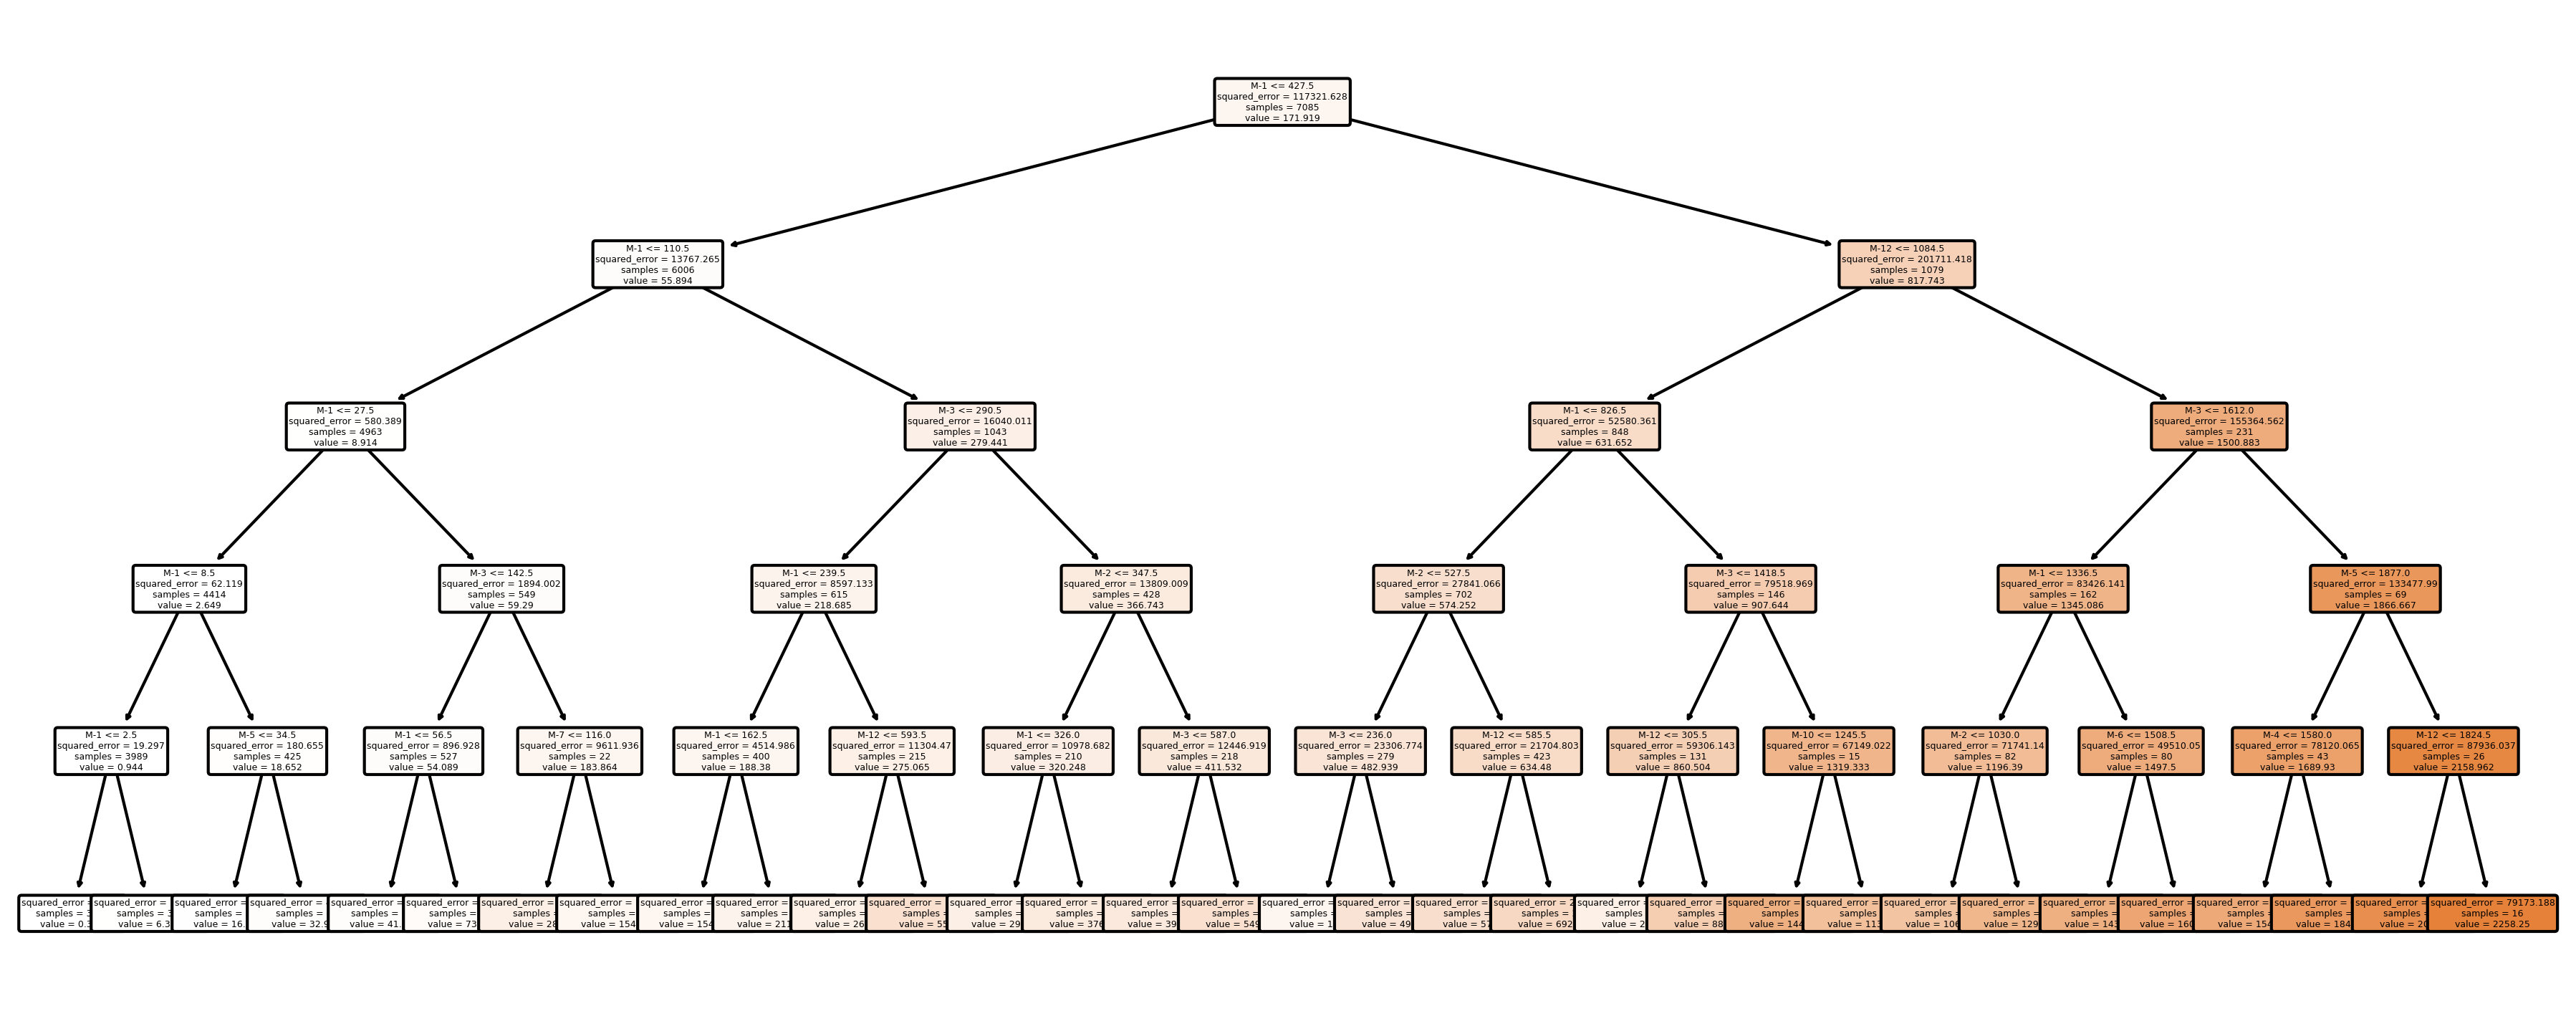

In [39]:
## Plotting Decision Tree

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,6), dpi = 300)
ax = fig.gca()

plot_tree(tree, fontsize=3, feature_names = [f'M{x-12}' for x in range(12)], rounded =  True, filled=True, ax=ax)

fig.savefig('Regression Tree.PNG')

In [60]:
## K FOLD CROSS VALIDATION RANDOM SEARCH ALGORITHM

max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,20)

param_dist = { 'max_depth' : max_depth,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf
             }

In [61]:
from sklearn.model_selection import RandomizedSearchCV

## MAE Optimized
tree = DecisionTreeRegressor()
tree_cv = RandomizedSearchCV(tree, param_dist, n_jobs = -1, cv = 10, verbose = 1, n_iter = 100, scoring ='neg_mean_absolute_error')

tree_cv.fit(X_train, Y_train)

print('Tuned regression Tree Parameters: ', tree_cv.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned regression Tree Parameters:  {'min_samples_split': 5, 'min_samples_leaf': 18, 'max_depth': 7}


In [62]:
Y_train_pred = tree_cv.predict(X_train)
Y_test_pred = tree_cv.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

        MAE  RMSE  Bias
Tree                   
Train  16.8  41.4   0.0
Test   18.1  45.5   3.1


In [63]:
from sklearn.model_selection import RandomizedSearchCV

## RMSE Optimized
tree = DecisionTreeRegressor()
tree_cv_rmse = RandomizedSearchCV(tree, param_dist, n_jobs = -1, cv = 10, verbose = 1, n_iter = 100, scoring ='neg_mean_squared_error')

tree_cv_rmse.fit(X_train, Y_train)

print('Tuned regression Tree Parameters: ', tree_cv_rmse.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned regression Tree Parameters:  {'min_samples_split': 7, 'min_samples_leaf': 9, 'max_depth': 7}


In [64]:
Y_train_pred = tree_cv_rmse.predict(X_train)
Y_test_pred = tree_cv_rmse.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

        MAE  RMSE  Bias
Tree                   
Train  15.9  38.5  -0.0
Test   19.2  47.4   3.4


In [65]:
df = pd.DataFrame(tree_cv.cv_results_)

df_params = pd.DataFrame(df['params'].values.tolist())
df = pd.concat([df_params,df], axis = 1)

df.to_excel('Results.xlsx')


In [66]:
## WISDOM OF CROWD - Random Forest

from sklearn.ensemble import RandomForestRegressor

## Bootstrap allows each tree to grow differently
forest = RandomForestRegressor(bootstrap = True, max_samples=0.95, max_features = 11, min_samples_leaf = 18, max_depth = 7)

forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'Forest')



         MAE  RMSE  Bias
Forest                  
Train   15.7  40.1   0.1
Test    18.3  47.2   3.8


In [67]:
##  Optimize Random Forest

max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,15)

max_features = range(3,8)

bootstrap = [True]

max_samples = [0.7, 0.8,0.9, 0.95, 1]

max_features = range(3,8)

param_dist = { 'max_depth': max_depth,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'max_features' : max_features,
               'bootstrap' : bootstrap,
               'max_samples' : max_samples}

## Estimators is for Trees
forest = RandomForestRegressor(n_jobs = 1 , n_estimators = 30)

forest_cv = RandomizedSearchCV(forest, param_dist, cv=6, n_jobs = -1, verbose = 2, n_iter = 400, scoring = 'neg_mean_absolute_error')

forest_cv.fit(X_train, Y_train)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


RandomizedSearchCV(cv=6,
                   estimator=RandomForestRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [5, 6, 7, 8, 9, 10, None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 15),
                                        'min_samples_split': range(5, 20)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [68]:
print('Tuned Forest Parmaters : ', forest_cv.best_params_)
print()

Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'Forest Optimized')

Tuned Forest Parmaters :  {'min_samples_split': 17, 'min_samples_leaf': 13, 'max_samples': 0.9, 'max_features': 5, 'max_depth': 10, 'bootstrap': True}

                   MAE  RMSE  Bias
Forest Optimized                  
Train             15.2  39.1   0.1
Test              18.1  45.9   3.1


In [69]:
## More estimators result is better accuracies but not beyond a certain point

forest = RandomForestRegressor(n_estimators=200, n_jobs=-1, **forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)

Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'Forestx200')


             MAE  RMSE  Bias
Forestx200                  
Train       15.1  38.7   0.1
Test        18.3  46.6   3.4


<AxesSubplot:>

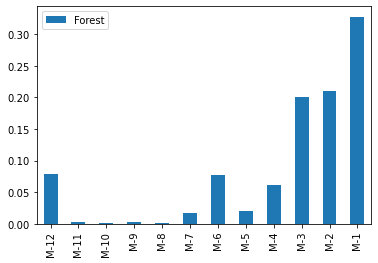

In [70]:
## Understanding the feature importance in model accuracy. That is which month demand is impacting the forecasts

cols = X_train.shape[1]
features = [f'M-{cols-col}' for col in range(cols)]

data = forest.feature_importances_.reshape(-1,1)

imp = pd.DataFrame(data=data, index=features, columns=['Forest'])
imp.plot(kind='bar')

In [ ]:
## The thress recent months have impact on forecast. The previous year month as well as impact. Half yeearly month 6 also 
## influences due to seasonality

In [72]:
### Extra Trees regressor choosed random split points for each tree and select the best among features.

from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor(n_jobs = -1, n_estimators = 200, min_samples_split = 15, min_samples_leaf = 4, max_samples=0.95, max_features = 4, max_depth = 8, bootstrap=True)  

ETR.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=8, max_features=4,
                    max_samples=0.95, min_samples_leaf=4, min_samples_split=15,
                    n_estimators=200, n_jobs=-1)

In [73]:
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'ETR')

        MAE  RMSE  Bias
ETR                    
Train  17.6  43.3   0.0
Test   18.8  46.7   3.1


In [74]:
##  Optimize Extreme Random Forest

max_depth = list(range(6,13)) + [None]
min_samples_split = range(7,16)
min_samples_leaf = range(2,13)

max_features = range(5,13)

bootstrap = [True]

max_samples = [0.7, 0.8,0.9, 0.95, 1]

max_features = range(3,8)

param_dist = { 'max_depth': max_depth,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'max_features' : max_features,
               'bootstrap' : bootstrap,
               'max_samples' : max_samples}

## Estimators is for Trees
ETR = ExtraTreesRegressor(n_jobs = 1 , n_estimators = 30)

ETR_cv = RandomizedSearchCV(ETR, param_dist, cv=5, n_jobs = -1, verbose = 2, n_iter = 400, scoring = 'neg_mean_absolute_error')

ETR_cv.fit(X_train, Y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


RandomizedSearchCV(cv=5,
                   estimator=ExtraTreesRegressor(n_estimators=30, n_jobs=1),
                   n_iter=400, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [6, 7, 8, 9, 10, 11, 12,
                                                      None],
                                        'max_features': range(3, 8),
                                        'max_samples': [0.7, 0.8, 0.9, 0.95, 1],
                                        'min_samples_leaf': range(2, 13),
                                        'min_samples_split': range(7, 16)},
                   scoring='neg_mean_absolute_error', verbose=2)

In [77]:
print('Tuned Forest Parmaters : ', ETR_cv.best_params_)
print()

Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'ETR Optimized')

Tuned Forest Parmaters :  {'min_samples_split': 7, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': 7, 'max_depth': 12, 'bootstrap': True}

                MAE  RMSE  Bias
ETR Optimized                  
Train          15.2  38.7   0.0
Test           17.9  45.3   3.0


In [78]:
## Use this as first GO To Model as ETR is better and as fast as Forest with lesser training time about 30%
ETR = ExtraTreesRegressor(n_estimators = 200, n_jobs = -1, **ETR_cv.best_params_).fit(X_train, Y_train)

Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)

kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'ETRx200')



          MAE  RMSE  Bias
ETRx200                  
Train    15.1  38.5   0.1
Test     17.7  45.3   2.7


In [80]:
df = import_data()
forest_features = { 'n_jobs':-1, 'n_estimators':200, 'min_samples_split':15, 'min_samples_leaf':4, 'max_samples':0.95, 'max_features':0.3,'max_depth':8, 'bootstrap':True}
forest = RandomForestRegressor(**forest_features)

ETR_features = { 'n_jobs':-1, 'n_estimators':200, 'min_samples_split':14, 'min_samples_leaf':2, 'max_samples':0.9, 'max_features':1.0,'max_depth':12, 'bootstrap':True}

ETR = ExtraTreesRegressor(**ETR_features)

models = [('forest',forest), ('ETR', ETR)]




In [81]:
def model_mae(model, X,Y):
    Y_pred = model.predict(X)
    mae = np.mean(np.abs(Y-Y_pred))/np.mean(Y)
    return mae


Model
ETRTest        14
ETRTrain       48
forestTest     30
forestTrain    48
dtype: int64


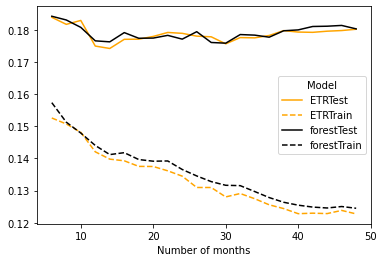

In [83]:
n_months = range(6,50,2)

results = []

for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df, x_len = x_len)
    
    for name , model in models:
        model.fit(X_train, Y_train)
        mae_train = model_mae(model, X_train, Y_train)
        mae_test = model_mae(model, X_test, Y_test)
        
        results.append([name+'Train', mae_train,x_len])
        results.append([name+'Test', mae_test,x_len])
        
data = pd.DataFrame(results, columns = ['Model','MAE%', 'Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')

data.index = data.index.droplevel(level=1)

data.index.name = 'Number of months'

data.plot(color =['orange']*2 + ['black']*2, style=['-','--']*2)

print(data.idxmin())


In [87]:
## Using K-fold validations to arrive at right feature numbers

from sklearn.model_selection import KFold

results = []

for x_len in n_months:
    X_train, Y_train, X_test, Y_test = datasets(df, x_len = x_len)
    for name, model in models:
        mae_kfold_train = []
        mae_kfold_val = []
        
        for train_index, val_index in KFold(n_splits = 8).split(X_train):
            X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
            Y_train_kfold, Y_val_kfold = Y_train[train_index], Y_train[val_index]
            
            model.fit(X_train_kfold, Y_train_kfold)
            
            mae_train = model_mae(model, X_train_kfold, Y_train_kfold)
            mae_val = model_mae(model,X_val_kfold,Y_val_kfold )
            
            mae_kfold_train.append(mae_train)
            mae_kfold_val.append(mae_val)
            
        results.append([name+' Val',np.mean(mae_kfold_val),x_len])
        results.append([name+' Train', np.mean(mae_kfold_train), x_len])
        
        model.fit(X_train, Y_train)
        
        mae_test = model_mae(model, X_test, Y_test)
        
        results.append([name+' Test', mae_test, x_len])
        
            

Model
ETR Test        12
ETR Train       40
ETR Val         42
forest Test     12
forest Train    44
forest Val      42
dtype: int64


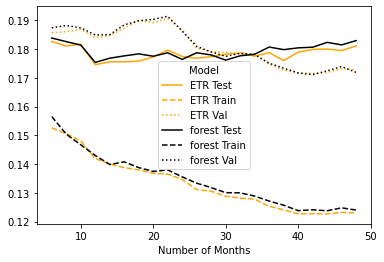

In [89]:
data = pd.DataFrame(results, columns = ['Model', 'MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')

data.index = data.index.droplevel(level=1)

data.index.name = 'Number of Months'

data.plot(color=['orange'] * 3+ ['black'] * 3, style=['-','--',':']*2)

print(data.idxmin())

In [ ]:
### Note that validation errors are high for lower order months. However for high order months , validation errors 
### are lower than the test errors. But this there is overfitting in validation set as well.

In [99]:
## APPROACH 3 : Holdout Set - 2nd Test Set

def datasets_holdout(df, x_len = 12, y_len = 1, test_loops = 12, holdout_loops = 0):
    D = df.values
    rows, periods = D.shape
    
    # Training set creations 
    train_loops = periods + 1 - x_len - y_len - test_loops
    train = []
    
    for col in range(train_loops):
        train.append(D[:, col:col+x_len+y_len])
        
    train = np.vstack(train)
    
    X_train, Y_train = np.split(train, [-y_len], axis = 1)
    
    ## Holdout set creation
    
    if holdout_loops > 0:
        X_train, X_holdout = np.split(X_train, [-rows*holdout_loops], axis = 0)
        Y_train, Y_holdout = np.split(Y_train, [-rows*holdout_loops], axis = 0)
        
    else :
        X_holdout, Y_holdout = np.array([]),np.array([])
        
    ## est Set Creation
    
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis = 0)
        Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis = 0)
    else : ## No test set: X_test is used to generate the future forecast
        X_test = D[:, -x_len:]
        Y_test = np.full((X_test.shape[0], y_len), np.nan)
        
    ## Formatting required for scikit-learn
    
    if y_len == 1:
        Y_train = Y_train.ravel()
        Y_test = Y_test.ravel()
        Y_holdout = Y_holdout.ravel()
        
        
    return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test
        
        
        
        
        

In [100]:
results = []

for x_len in n_months:
    X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len = x_len, holdout_loops = 12)
    
    for name, model in models:
        model.fit(X_train, Y_train)
        
        mae_train = model_mae(model, X_train, Y_train)
        mae_holdout = model_mae(model, X_holdout, Y_holdout)
        mae_test = model_mae(model, X_test, Y_test)
        
        results.append([name+' Train', mae_train, x_len])
        results.append([name+' Test', mae_test, x_len])
        results.append([name+' Holdout', mae_holdout, x_len])
        

Model
ETR Holdout       24
ETR Test          12
ETR Train         44
forest Holdout    18
forest Test       12
forest Train      42
dtype: int64


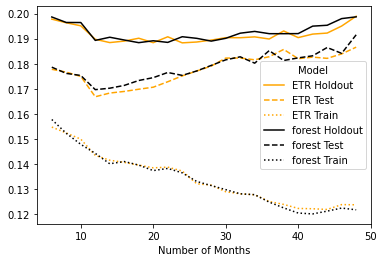

In [101]:
data = pd.DataFrame(results, columns = ['Model','MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')

data.index = data.index.droplevel(level=1)

data.index.name = 'Number of Months'

data.plot(color=['orange']*3 + ['black']*3, style = ['-','--',':']*3)

print(data.idxmin())

In [ ]:
## ADAPTIVE BOOSTING TECHNIQUE - not recommended to use it
## Can a set of weak learners create strong learning




